In [209]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read, write
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

def read_raw_y(file_path):
    if not os.path.isfile(file_path): 
        raise ValueError("Input file is wrong")

    return read(file_path)


def write_wav_file(file_path, fs, y):
    write(file_path, fs, y)
    
    
def get_stft(fs, signal):
    SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
    return SFT.stft(signal)      
    
def threshold_frequencies(magnitudes, probability_threshold, magnitude_threshold):
    t, f = magnitudes.shape
    max_magnitude = np.max(np.abs(magnitudes))
    probabilities = np.mean(np.abs(magnitudes) > magnitude_threshold*max_magnitude, axis=0)  # Compute overall probability 
    
    indicator_array = np.zeros(f, dtype=int)
    indicator_array[probabilities > probability_threshold] = 1

    mean_magnitudes = np.zeros(f)
    mean_magnitudes[indicator_array == 1] = np.mean(np.abs(magnitudes)[:, indicator_array == 1], axis=0)

    return mean_magnitudes

def reduce_amplitude(frequency_component, reduction):
    magnitude = np.abs(frequency_component)
    phase = np.angle(frequency_component)
    
    reduced_magnitude = max(magnitude - reduction,0)
    reduced_frequency_component = reduced_magnitude * np.exp(1j * phase)

    return reduced_frequency_component


def reduce_magnitudes(stft, indicator_array):
    new_stft = stft.copy()
    for i in range(new_stft.shape[1]):
        for j, magnitude in np.ndenumerate(indicator_array):
            if magnitude == 0:
                continue
            new_stft[j][i] = reduce_amplitude(new_stft[j][i], magnitude)
    return new_stft


def q1(audio_path) -> np.array:
    """
    :param audio_path: path to q1 audio file
    :return: return q1 denoised version
    """
    (fs, signal) = read_raw_y(audio_path)
    stft = get_stft(fs, signal)
    indicator_array = threshold_frequencies(stft.T, probability_threshold, magnitude_threshold)
    new_stft = reduce_magnitudes(stft, indicator_array)
    return SFT.istft(new_stft, k1=len(signal))

    

# PARAMS
window_length = 400
window_step = 10
gaussian_std = 50  # standard deviation for Gaussian window in samples
gaussian_window = window_step*10
window_function = gaussian(gaussian_window, std=gaussian_std, sym=True)  # symmetric Gaussian window

# Set the thresholds 
probability_threshold = 0.5
magnitude_threshold = 0.05


In [211]:
audio_path = './assets/q2.wav'
(fs, signal) = read_raw_y(audio_path)
N = len(signal)
stft = get_stft(fs, signal)



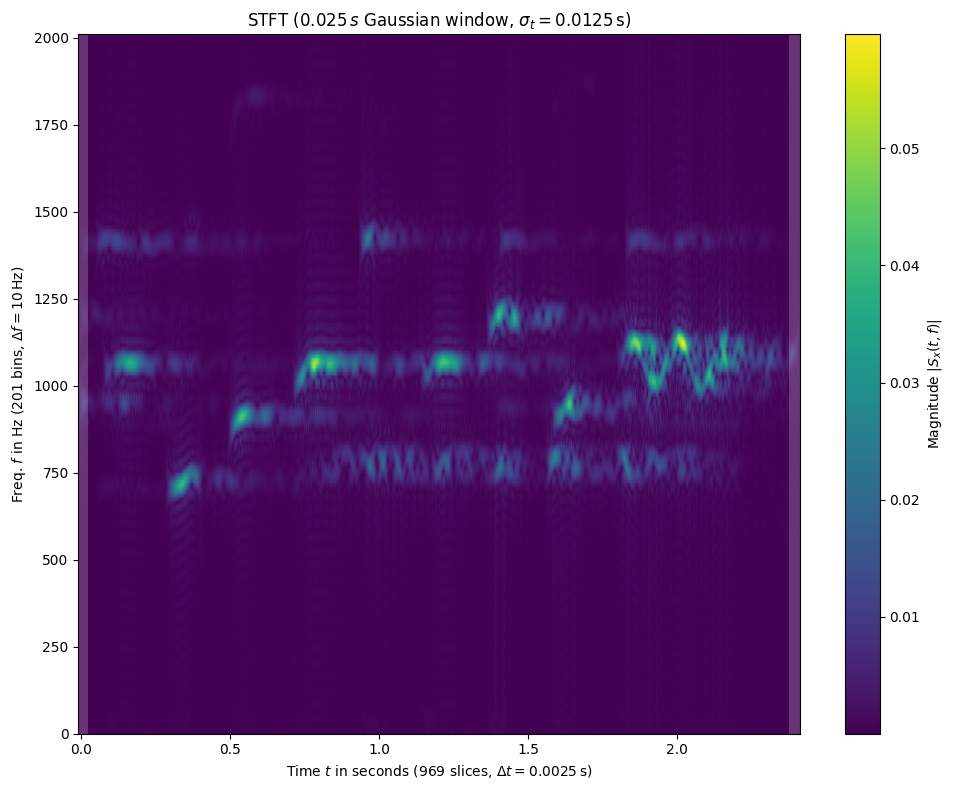

In [244]:
SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')

def remove_rectangle(stft, sec, min_frequency, window_step, window_length):
    start_t = math.floor(N * sec / 2.5 / window_step )
    max_f = math.floor(window_length * min_frequency / 2 / 2000 )
    new_stft = stft.copy()
    new_stft.T[start_t:,:max_f] = 0
    return new_stft

new_stft = stft #remove_rectangle(stft, 0.7, 840, window_step, window_length)
new_sound = SFT.istft(new_stft, k1=len(signal))
write_wav_file('./assets/new_sound_2.wav', fs, new_sound)

fig1, ax1 = plt.subplots(figsize=(10., 8.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))



im1 = ax1.imshow(abs(new_stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

fig1.tight_layout()
plt.show()

In [226]:
# window_length * 750 / 2 / 2000 
# N * 1 / 2.5 / window_step 

384.0

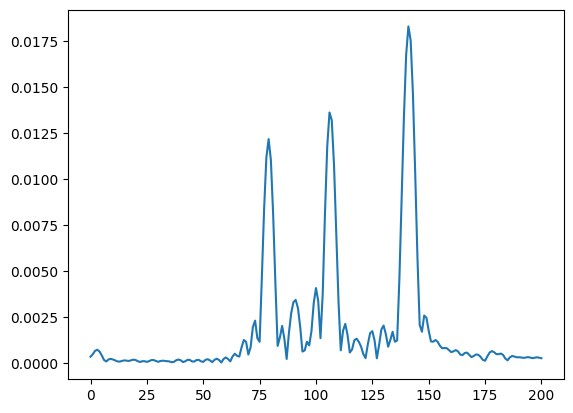

In [227]:
# plt.plot(np.abs(stft[75]))
plt.plot(np.abs(stft.T[384]))


In [ ]:


SFT = ShortTimeFFT(window_function, hop=window_step, fs=fs, mfft=window_length, scale_to='magnitude')
fig1, ax1 = plt.subplots(figsize=(10., 8.))  # enlarge plot a bit
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax1.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Gaussian window, " +
              rf"$\sigma_t={gaussian_std*SFT.T}\,$s)")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))


# im1 = ax1.imshow(abs(stft), origin='lower', aspect='auto',
#                  extent=SFT.extent(N), cmap='viridis')
im1 = ax1.imshow(abs(stft), origin='lower', aspect='auto', extent = SFT.extent(N) , cmap='viridis')
fig1.colorbar(im1, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T),
                 (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax1.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)

fig1.tight_layout()
plt.show()